# NMF

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from surprise import Dataset, Reader, SVD, NMF
from surprise.model_selection import GridSearchCV, RandomizedSearchCV

DATA_DIR = '../../Data/'
train_path = os.path.join(DATA_DIR, 'train_ratings.csv')
tbr_path = os.path.join(DATA_DIR, 'train_tbr.csv')
submission_path = os.path.join(DATA_DIR, 'sample_submission.csv')
output_path = os.path.join(DATA_DIR, 'sample_submissionNMF.csv')

In [18]:
def load_data(train_path):
    """
    Load ratings CSV, split sid_pid into sid and pid, drop original column.
    """
    ratings = pd.read_csv(train_path)
    ratings[["sid", "pid"]] = ratings["sid_pid"].str.split("_", expand=True)
    ratings.drop(columns=["sid_pid"], inplace=True)
    ratings["sid"] = ratings["sid"].astype(int)
    ratings["pid"] = ratings["pid"].astype(int)
    return ratings

def build_dataset(ratings, rating_scale=(1,5)):
    """
    Convert a pandas DataFrame to a Surprise Dataset.
    """
    reader = Reader(rating_scale=rating_scale)
    return Dataset.load_from_df(ratings[["sid", "pid", "rating"]], reader)

def generate_submission(algo, dataset, submission_path, output_path):
    """
    Fit algo on full training set, predict on sample_submission file, and save to CSV.
    """
    trainset = dataset.build_full_trainset()
    algo.fit(trainset)

    sub = pd.read_csv(submission_path)
    sub[["sid", "pid"]] = sub["sid_pid"].str.split("_", expand=True).astype(int)
    testset = list(zip(sub["sid"], sub["pid"], sub["rating"]))

    preds = algo.test(testset)
    sub["rating"] = [p.est for p in preds]
    out = sub[["sid_pid", "rating"]]
    out.to_csv(output_path, index=False)
    print(f"Submission saved to {output_path}")

In [19]:
def run_search(estimator_class, param_grid, data, cv=5, n_jobs=-1, search_type="grid", n_iter=50, random_state=42):
    """
    Perform hyperparameter search. Returns search object and DataFrame of cv results.
    """
    if search_type == "grid":
        search = GridSearchCV(estimator_class, param_grid, measures=["rmse"], cv=cv, n_jobs=n_jobs)
    elif search_type == "random":
        search = RandomizedSearchCV(
            estimator_class,
            param_grid,
            measures=["rmse"],
            n_iter=n_iter,
            cv=cv,
            random_state=random_state,
            n_jobs=n_jobs,
        )
    else:
        raise ValueError("search_type must be 'grid' or 'random'")

    search.fit(data)
    results = pd.DataFrame(search.cv_results)
    return search, results

In [11]:
def plot_param(df, best_params, param, y_mean='mean_test_rmse', y_std='std_test_rmse'):
    """
    Plot RMSE vs single hyperparameter by fixing all others to best_params.
    """
    df_f = df.copy()
    for p, v in best_params.items():
        if p != param:
            df_f = df_f[df_f[f'param_{p}'] == v]
    agg = df_f.groupby(f'param_{param}').agg({
        y_mean: 'mean',
        y_std: 'mean'
    }).reset_index()
    x = agg[f'param_{param}'].astype(float)
    y = agg[y_mean]
    yerr = agg[y_std]

    fig, ax = plt.subplots()
    ax.errorbar(x, y, yerr=yerr, fmt='-o', capsize=3)
    ax.set_xlabel(param)
    ax.set_ylabel('RMSE')
    ax.set_title(f'RMSE vs {param} (others fixed to best)')
    ax.grid(True)
    plt.tight_layout()
    plt.show()

In [12]:
# Load data
ratings = load_data(train_path)
dataset = build_dataset(ratings)

In [13]:
# Hyperparameter search

# Best RMSE: 0.8494779867831251
# Best Params: {'n_epochs': 200, 'n_factors': 300, 'reg_pu': 0.04, 'reg_qi': 0.08}

# Best RMSE: 0.8494206405640934
# Best Params: {'n_epochs': 200, 'n_factors': 300, 'reg_pu': 0.03, 'reg_qi': 0.085}

param_grid = {
    'n_epochs': [200], # 50,100,150,175,200
    'n_factors': [300], # 50,100,200,250,300
    'reg_pu': [0.02, 0.03, 0.035], # 0.02,0.03,0.035, 0.04, 0.06, 0.07,0.08, 0.09
    'reg_qi': [0.07, 0.08, 0.085] # 0.04, 0.06,0.07, 0.08,0.085, 0.09, 1.00
}

gs, results = run_search(NMF, param_grid, dataset, search_type='grid')
best = gs.best_params['rmse']
print('Best RMSE:', gs.best_score['rmse'])
print('Best Params:', best)


Best RMSE: 0.8494206405640934
Best Params: {'n_epochs': 200, 'n_factors': 300, 'reg_pu': 0.03, 'reg_qi': 0.085}


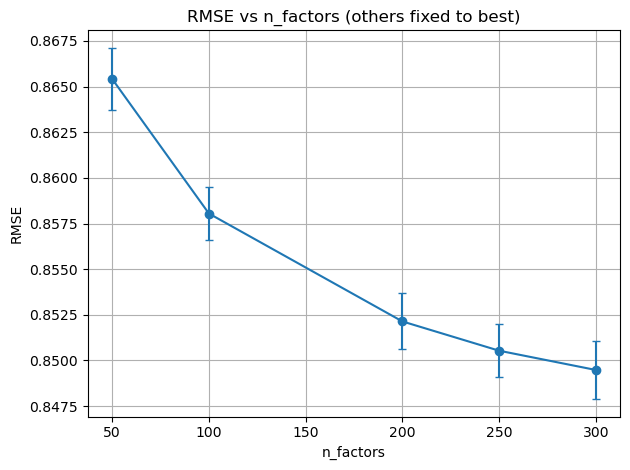

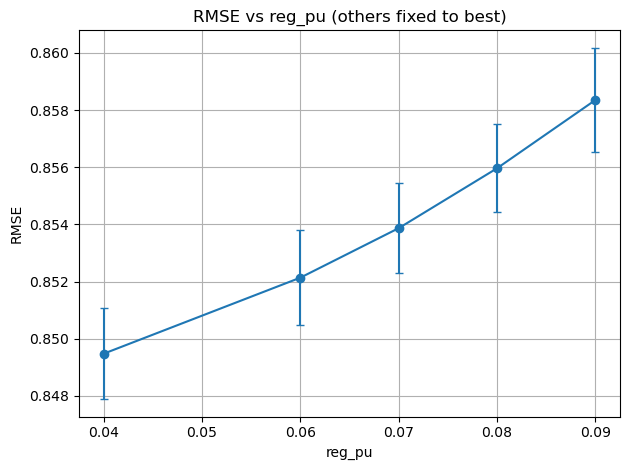

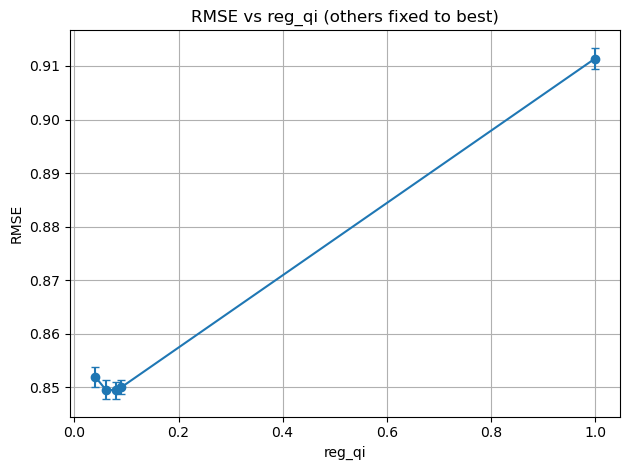

In [8]:
# Plots
plot_param(results, best, 'n_factors')
plot_param(results, best, 'reg_pu')
plot_param(results, best, 'reg_qi')

In [37]:
#Best Params: {'n_epochs': 200, 'n_factors': 300, 'reg_pu': 0.03, 'reg_qi': 0.085}

# Train the model with best parameters
best_nmf = NMF(
    n_epochs=200,
    n_factors=300,
    reg_pu=0.03,
    reg_qi=0.085
)

In [38]:
# Generate submission
generate_submission(best_nmf, dataset, submission_path, output_path)

Submission saved to /Users/ccylmichel/Documents/CIL/BayesWatch_CollaborativeFiltering/Data/sample_submissionNMF.csv


## Adding Implicit rating

In [41]:

def load_tbr_data(train_path):
    """
    Load ratings CSV, split sid_pid into sid and pid, drop original column.
    """
    implicit_df = pd.read_csv(train_path)
    implicit_df["sid"] = implicit_df["sid"].astype(int)
    implicit_df["pid"] = implicit_df["pid"].astype(int)
    return implicit_df


def impute_weighted_wide(mat: pd.DataFrame, implicit_df: pd.DataFrame, row_weight: float = 1, col_weight: float = 0) -> pd.DataFrame:
    """
    mat: pivoted DataFrame, index=sid, columns=pid
    implicit_df: [sid,pid] pairs to fill
    """

    # get the raw numpy matrix
    A = mat.values.copy()
    # compute row‐means / column‐means once
    rmean = np.nanmean(A, axis=1)
    cmean = np.nanmean(A, axis=0)

    # turn sids/pids into positional indices
    ridx = mat.index.get_indexer(implicit_df["sid"])
    cidx = mat.columns.get_indexer(implicit_df["pid"])

    # vectorized compute of all new entries
    vals = row_weight * rmean[ridx] + col_weight * cmean[cidx]
    A[ridx, cidx] = vals

    return pd.DataFrame(A, index=mat.index, columns=mat.columns)


In [42]:
# Load data
ratings = load_data(train_path)
mat = ratings.pivot(index="sid", columns="pid", values="rating")
implicit_data = load_tbr_data(tbr_path)
# Impute values
imputed_data = impute_weighted_wide(mat, implicit_data, row_weight=0.75, col_weight=0.25)
imputed_data = imputed_data.stack().reset_index(name="rating").rename(columns={"level_0":"sid", "level_1":"pid"})

# Build Dataset
dataset = build_dataset(imputed_data)


In [43]:
# 2nd Best model from the first part
generate_submission(best_nmf, dataset, submission_path, output_path)

Submission saved to /Users/ccylmichel/Documents/CIL/BayesWatch_CollaborativeFiltering/Data/sample_submissionNMF.csv
